# Named entity recognition

### Sort bills according to their size and take top 50

In [1]:
import pandas as pd
import utils

In [2]:
documents = utils.read_documents()

In [3]:
documents_top_50 = dict(sorted(documents.items(), reverse=True, key=lambda x: len(x[1]))[:50])

In [4]:
pd.DataFrame(
    [(k, len(v)) for k, v in documents_top_50.items()],
    columns=['id', 'length']
).head()

,id,length
0,2000_696.txt,560054
1,2001_627.txt,397912
2,1996_465.txt,396433
3,1997_555.txt,377867
4,2002_1689.txt,335096


### Use the lemmatized and sentence split documents to identify the expressions that consist of consecutive words starting with a capital letter

In [5]:
import re

In [6]:
ANALYSIS_PATH = "./ustawy_analyzed/"

In [7]:
documents_analyzed = utils.read_documents(ANALYSIS_PATH)

In [8]:
documents_analyzed_top_50 = {k: v for k, v in documents_analyzed.items() if k.replace("ustawy%", '') in list(documents_top_50)}

In [9]:
documents_base = [utils.get_base_text(d) for d in documents_analyzed_top_50.values()]

In [10]:
pattern = re.compile(r"\b([A-Z][^\s]*(?:\s[A-Z][^\s]*)*)\b")
[x.split() for x in re.findall(pattern, documents_base[2]) if len(x.split()) > 1]

[['Rzeczpospolita', 'Polska'], ['Rzeczpospolita', 'Polska']]

In [11]:
def find_capitalized_expressions(documents):
    pattern = re.compile(r"\b([A-Z][^\s]*(?:\s[A-Z][^\s]*)*)\b")
    return [e for d in documents for e in pattern.findall(d)]

In [12]:
expr = find_capitalized_expressions(documents_base)

### Compute the frequency of each identified expression

In [34]:
import pandas as pd
from collections import Counter

In [14]:
pd.DataFrame((Counter(expr).items()),
             columns=['expression', 'count']) \
    .sort_values(by='count', ascending=False) \
    .reset_index(drop=True) \
    .head(50)

,expression,count
0,Art,9468
1,Dzieje_(Apostolskie,1105
2,D,523
3,II,260
4,III,216
5,Polska,195
6,P2O5,120
7,Wolny,117
8,EFTA,114
9,IV,113


### Apply the NER algorithm

In [ ]:
from xml.etree import ElementTree as ET

In [27]:
CLARIN_ANALYZER = 'any2txt|wcrft2|liner2({"model":"n82"})'
OUTPUT_FILE = "./lab7/ustawy_top_50_ner.txt"

In [ ]:
utils.clarine(documents_top_50, lpmn=CLARIN_ANALYZER)

In [31]:
with open(OUTPUT_FILE, 'r') as f:
    documents_clarin = f.read()

In [56]:
expressions = []
root = ET.fromstring(documents_clarin)
for sentence in root.findall('./chunk/sentence'):
    sentence_id = sentence.get("id")
    for tok in sentence.findall("tok"):
        base = tok.find("lex/base").text
        for ann in tok.findall("ann") or []:
            ann_id = int(ann.text)
            ann_chan = ann.get("chan")
            expressions.append((sentence_id, base, ann_chan, ann_id))

In [64]:
df_expressions = pd.DataFrame(expressions, columns=['sentence_id', 'expression', 'class', 'class_id']) \
    .groupby(['sentence_id', 'class', 'class_id'])['expression'] \
    .apply(lambda x: ' '.join(x)) \
    .reset_index() \
    .assign(coarse_grained_class=lambda x: x['class'].str[:7])
df_expressions.head()

,sentence_id,class,class_id,expression,coarse_grained_class
0,s1,nam_pro_media_periodic,0,z 2001 r .,nam_pro
1,s1,nam_pro_media_periodic,1,Dzieje_(Apostolskie) . u .,nam_pro
2,s1000,nam_org_institution,0,zadanie z zakres ubezpieczenie zdrowotny reali...,nam_org
3,s1000,nam_org_institution,1,krajowy związek kasa powszechny ubezpieczenie ...,nam_org
4,s1000,nam_org_organization,0,zadanie z zakres ubezpieczenie zdrowotny reali...,nam_org


### Plot the frequency of the coarse-grained classes

In [65]:
import matplotlib.pyplot as plt

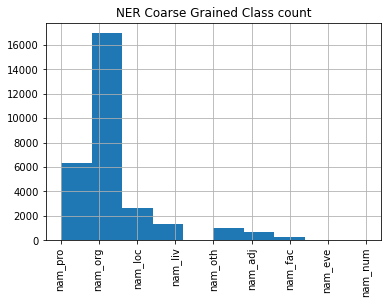

In [66]:
df_expressions['coarse_grained_class'].hist()
plt.xticks(rotation='vertical')
plt.title("NER Coarse Grained Class count")
plt.show()

### Display 10 most frequent Named Entities for each coarse-grained type

In [67]:
pd.set_option('display.max_rows', None)

df_expressions.groupby('coarse_grained_class') \
    .apply(lambda grp: grp.groupby('expression')
           .size()
           .nlargest(10)) \
    .to_frame('count')

count
coarse_grained_class expression                                               
nam_adj              polski                                                204
                     wojewódzki                                             20
                     europejski                                             15
                     mazowiecki                                              7
                     internetowy                                             5
                     macierzyński                                            3
                     warszawski                                              3
                     afrykański                                              2
                     brzeski                                                 2
                     chełmiński                                              2
nam_eve              euro                                                    5
                     maksymalny limit pozostałość                            4
                     monitor sądowy                                          2
                     przejściowy plan krajowy                                2
                     , bit ) dla produkt leczniczy dopuścić do obrót...      1
                     , cent ) obywatel polski za granica " w organiz...      1
                     26 oddział 2 zgłoszenie w forma pisemny ( art ....      1
                     II wojna światowy                                       1
                     R1 wykorzystanie jako paliwo lub inny środek wy...      1
                     R5 recykling                                            1
nam_fac              inspektor nadzór wewnętrzny                            50
                     straż graniczny                                        18
                     obrona narodowy                                        10
                     mangan                                                  8
                     krajowy rejestr karny                                   5
                     molibden                                                4
                     zasłużony dawca przeszczep                              4
                     zatoka gdańska                                          4
                     MN                                                      3
                     komendant główny                                        3
nam_liv              kasa chora                                            109
                     główny inspektor                                       49
                     Pan                                                    38
                     straż graniczny                                        31
                     krajowy depozyt                                        26
                     siła zbrojny                                           23
                     gospodarka żywnościowy                                 22
                     Art                                                    18
                     najwyższy                                              13
                     generalny dyrektor droga publiczny                     12
nam_loc              rzeczpospolita polski                                 794
                     Rzeczpospolita Polska                                  91
                     Polska                                                 72
                     Warszawa                                               71
                     nawóz                                                  28
                     konfederacja szwajcarski                               14
                     rejestr                                                 8
                     Londyn                                                  7
                     mazowiecki                                              7
                     Bruksela               

### Display 50 most frequent Named Entities including their count and fine-grained type

In [68]:
pd.set_option('display.max_rows', None)

df_expressions \
    .groupby(["expression", "class"]) \
    .size() \
    .nlargest(50) \
    .to_frame("count")

,,count
expression,class,
Dzieje_(Apostolskie) . u .,nam_pro_media_periodic,1097
rzeczpospolita polski,nam_loc_gpe_country,794
dziennik . u .,nam_pro_media_periodic,438
skarb państwo,nam_org_institution,410
złoty,nam_oth_currency,334
minister sprawiedliwość,nam_org_institution,322
unia europejski,nam_org_organization,296
minister obrona narodowy,nam_org_institution,287
rada minister,nam_org_institution,278


### Display 5 sentences containing at least 2 recognized named entities with different types

In [84]:
df_tmp = df_expressions.groupby('sentence_id') \
    .apply(lambda grp: (len(grp['class'].unique()), grp['expression'])) \
    .to_frame() \
    .iloc[:, 0].apply(pd.Series)
df_tmp[df_tmp.iloc[:, 0] > 1]

,0,1
sentence_id,,
s1000,2,2 zadanie z zakres ubezpieczenie zdrowotny ...
s10001,2,"6 zarządzający być obowiązany , z zastrzeż..."
s1002,2,19 regionalny kasa i branżowy kasa być czło...
s10023,2,25 do zakres działanie należeć między inny ...
s10024,2,31 ubezpieczenie społeczny oraz środek fund...
s10070,4,"79 projekt i sprawozdanie , o który mowa w ..."
s10073,2,87 rada nadzorczy zakład składać się z 15 o...
s10075,2,92 do zadanie rad nadzorczy zakład należeć ...
s10080,2,102 zakład uzyskiwać przychod z : 1 ) odpis...
